# Turtlebot Tutorial
Welcome to the tutorial. Here you will learn to:
* Read data from the robots services
* Drive the robot around
* Look at the laser scanner data
* Find way to navigate the environment
* Make the robot follow an object

Next, just execute the code cells below in sequence, read the comments, the output, and see what happens.

Don't worry, you can modify this code as you like. To save your own version, click File->Save as... and enter a new name. After you leave, the content of this notebook will automatically revert to the original state. However, if possible please re-dock the robot after use (By executing one of the cell with `robot.dock()`. In case this does not work, don't worry we will take note and help the robot back onto it's base. In case there are any questions feel free to contact us at robohub@uwaterloo.ca
If you want to take your code home with you later, click File->Make a Copy and enter a new name now. Otherwise all changes will be temporary.

In [1]:
# load ROS library
import rclpy
if not rclpy.ok():
    rclpy.init()

# Load Robot ROS wrapper

In [2]:
from robot_wrapper import Robot
# Instantiate Wrapper. The subscribers and publishes the relevant topics and connects the actions.
robot = Robot()

# Example: Read data from topics

In [3]:
# Check Battery State. Note: 10% get you TODO minutes of runtime.
robot.battery_state_future = rclpy.Future()
robot.spin_until_future_completed(robot.battery_state_future);
print("Battery {0:2.3}%, charging with {1:2.2}A".format(
    robot.last_battery_state_msg.percentage*100,
    robot.last_battery_state_msg.current
))

Battery 24.0%, charging with -0.88A


In [4]:
# Wait for initial data on the subscribed topics
robot.spin_until_future_completed(robot.scan_future); # Lidar
robot.spin_until_future_completed(robot.odom_future); # Odometry
robot.spin_until_future_completed(robot.imu_future); # IMU
robot.spin_until_future_completed(robot.image_future); # Camera image
robot.spin_until_future_completed(robot.camera_info_future); # Camera calibration data
robot.spin_until_future_completed(robot.battery_state_future); # Battery status
# This also confirms all services are running

# Example: Drive the robot via teleoperation

In [ ]:
# Use preprogrammed behavior: Drive off the dock in a controlled way
robot.undock()

In [5]:
robot.generate_buttons()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [ ]:
robot.dock()

# Example: Detect April tags with OpenCV
For this example, you need a printed April tag label from the series 36h11. Alternatively change the code. To generate numerically useful results and for verification, a ruler or tape measure is necessary as well.

In [ ]:
robot.undock()

In [6]:
# Put marker in front of camera
# Take image and convert to in opencv format
robot.image_future = rclpy.Future()
robot.spin_until_future_completed(robot.image_future)

import cv2 # important to prevent triggering a bug when loading cv_bridge
from cv_bridge import CvBridge, CvBridgeError
bridge = CvBridge()
try:
    cv_image = bridge.imgmsg_to_cv2(robot.last_image_msg, "passthrough")
except CvBridgeError as e:
    rospy.logerr("CvBridge Error: {0}".format(e))

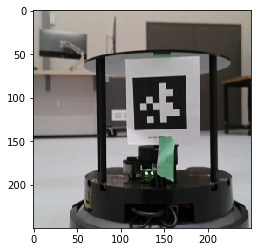

In [7]:
# Display image
import cv2
import numpy as np
rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
from matplotlib import pyplot as plt
plt.imshow(rgb_image)
plt.show()

In [8]:
# Detect aruco markers
adict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_APRILTAG_36h11)
res = cv2.aruco.detectMarkers(
    cv_image,
    dictionary=adict,
    cameraMatrix=robot.last_camera_info_msg.k,
    distCoeff=np.array(robot.last_camera_info_msg.d)
)
print("Found ids: {}".format(res[1]))

Found ids: [[7]]


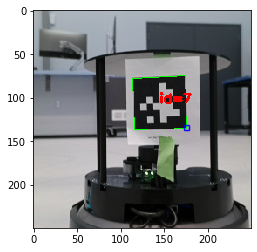

In [9]:
# Plot detected markers in picture
frame_markers = cv2.aruco.drawDetectedMarkers(cv_image.copy(), res[0], res[1])
from matplotlib import pyplot as plt
plt.imshow(frame_markers)
plt.show()

In [10]:
# Compute marker position in camera frame
# TODO: fix this. Unclear error
rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
                                    res[0],
                                    0.08,
                                    robot.last_camera_info_msg.k.reshape((3,3)),
                                    np.array(robot.last_camera_info_msg.d))
print(f"rvec = {rvec}")
print(f"tvec = {tvec}")

rvec = [[[-0.05295303 -3.09129867  0.02733406]]]
tvec = [[[ 0.02734515 -0.02762973  0.2742404 ]]]


# Example: Visual servoing with april tags

In [11]:
# 1. drive a bit, recompute cmd_vel from april pose
# 2. understand how non-holonomic property motivates path planning to increase robustness
import time

def grab_image():
    robot.image_future = rclpy.Future()
    robot.spin_until_future_completed(robot.image_future)
    
    try:
        cv_image = bridge.imgmsg_to_cv2(robot.last_image_msg, "passthrough")
    except CvBridgeError as e:
        rospy.logerr("CvBridge Error: {0}".format(e))
    return cv_image

distance_ref = 0.25
Kp = -3
Kp_head = -5
st = time.time()

prev_marker_loc = -0.1
while (True):
    img = grab_image()
    res = cv2.aruco.detectMarkers(
                    img,
                    dictionary=adict,
                    cameraMatrix=robot.last_camera_info_msg.k,
                    distCoeff=np.array(robot.last_camera_info_msg.d))

    rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
                                    res[0],
                                    0.08,
                                    robot.last_camera_info_msg.k.reshape((3,3)),
                                    np.array(robot.last_camera_info_msg.d))
    if not np.all(tvec):
        phi = 3*Kp_head * prev_marker_loc 
        robot.set_cmd_vel(0.0, phi, 0.1)
        continue
        
    tvec = tvec.reshape(3)
#     print(f"Curr dist = {tvec[-1]} m")
    e = distance_ref - tvec[-1]
    e_head = tvec[0]
    prev_marker_loc = e_head
    
    if abs(e) < 0.02:
        velocity_x = 0
    else:
        velocity_x = Kp * e
    
    if abs(e_head) < 0.05:
        velocity_phi = 0
    else:
        velocity_phi = Kp_head * e_head
        
    
#    print(velocity_phi)

    duration = 0.25 # in s
    et = time.time()
#     print(et - st)
    st = et
    robot.set_cmd_vel(velocity_x, velocity_phi, duration)

KeyboardInterrupt: 